In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_scheduler.scheduler.utils import CurrentAreaMap, Footprint, make_rolling_footprints
from rubin_scheduler.utils import DEFAULT_NSIDE, SURVEY_START_MJD
from rubin_scheduler.site_models import Almanac
import sqlite3
import pandas as pd
from os.path import basename
from rubin_sim.data import get_baseline

import rubin_sim.maf_proto as maf


In [2]:
# Read in a small example visit history
baseline_file = get_baseline()
run_name = basename(baseline_file).replace('.db', '')
con = sqlite3.connect(baseline_file)
# Dataframe is handy for some calcs
df = pd.read_sql("select * from observations where night < 730;", con)
# But mostly want numpy array for speed.
visits_array = df.to_records(index=False)
con.close()


In [3]:
# figure out first night a healpix could be visible
nside = 64

mjd_start = SURVEY_START_MJD
nslice = 2

sky = CurrentAreaMap(nside=nside)
footprints_hp_array, labels = sky.return_maps()

almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

wfd_indx = np.where((labels == "lowdust") | (labels == "virgo"))[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprints = make_rolling_footprints(
        fp_hp=footprints_hp,
        mjd_start=mjd_start,
        sun_ra_start=sun_ra_start,
        nslice=nslice,
        nside=nside,
        wfd_indx=wfd_indx,
        order_roll=1,
        n_cycles=3,
        uniform=True,
    )


In [89]:

earliest_night = np.zeros(hp.nside2npix(nside))
tracking = np.zeros(hp.nside2npix(nside))

In [90]:
tracking_limit = 20
previous = np.zeros(hp.nside2npix(nside))
for night in np.arange(366):
    fp = footprints(mjd_start + night)
    indx = np.where((fp["r"] > 0) & (earliest_night == 0) & (tracking >= tracking_limit))
    earliest_night[indx] = night

    diff = fp["r"] - previous
    
    tracking[np.where(diff > 0)] += 1
    previous = fp["r"] + 0

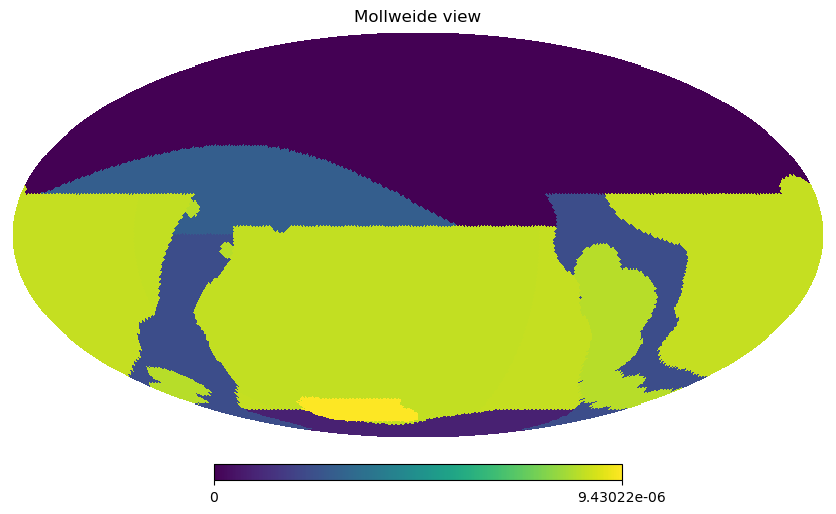

In [91]:
hp.mollview(fp["r"])

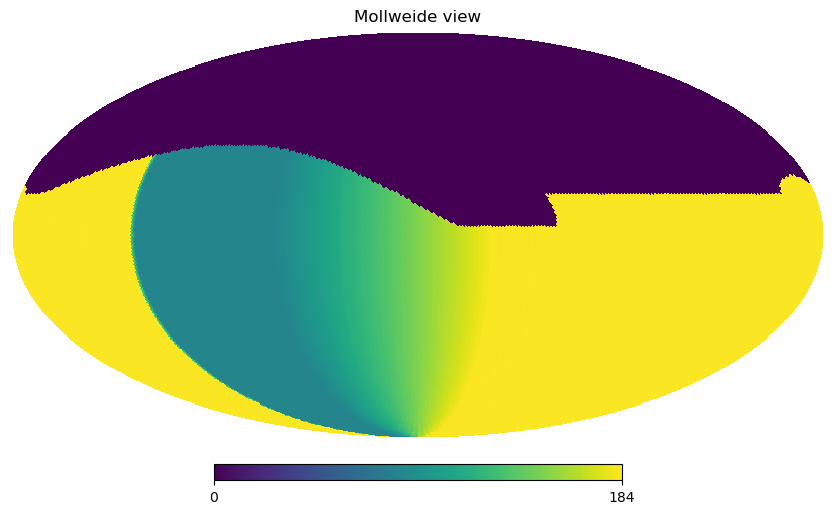

In [92]:
hp.mollview(tracking)

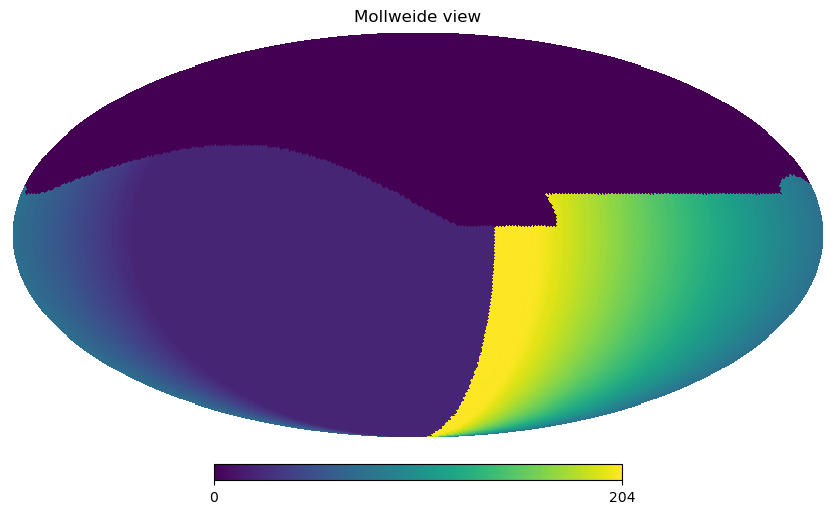

In [93]:
hp.mollview(earliest_night)

In [94]:
class night_at_three():
    def __call__(self, data_slice, slice_point=None):
        data_slice.sort(order="night")
        if np.size(data_slice) < 3:
            return np.nan
        else:
            return data_slice["night"][2]

In [95]:
sl = maf.Slicer(nside=nside)


In [96]:
sub_indx = np.where((visits_array["filter"] == "g") & (visits_array["visitExposureTime"] > 22.))

In [97]:

hp_array = sl(visits_array[sub_indx], night_at_three())

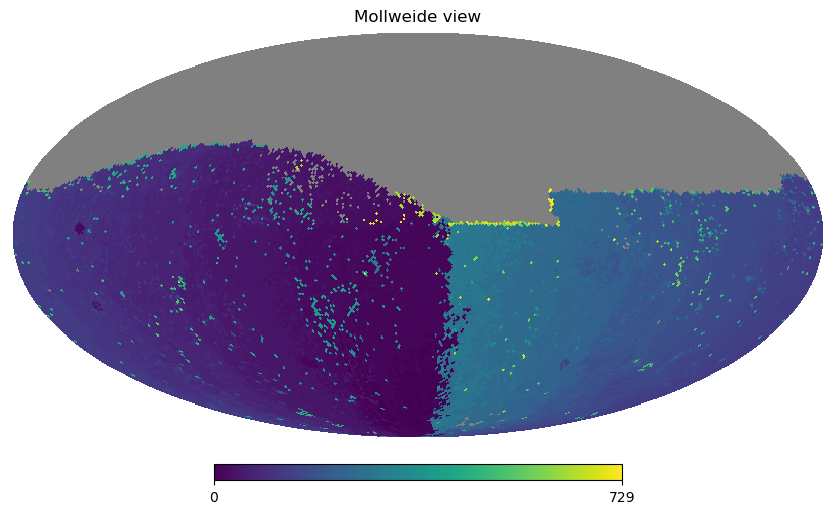

In [100]:
hp.mollview(hp_array)

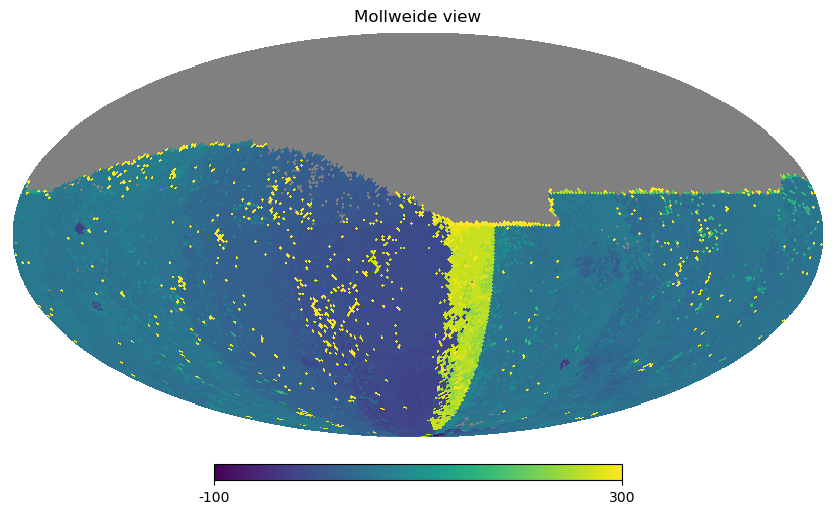

In [98]:
hp.mollview(hp_array - earliest_night, max=300, min=-100)

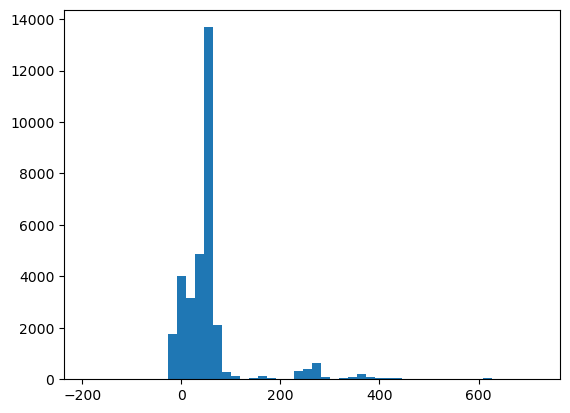

In [99]:
_ack = plt.hist(hp_array - earliest_night, bins=50)